# Analyzing Cross-Source Patterns in Similar Profiles

**Purpose**:
  1. Load the results from the similarity query performed in Notebook 06 (the
     query profile ID and the list of similar profile IDs).
  2. Retrieve the relevant *original* data records (from the raw synthetic files
     generated in Notebook 00) for the query profile and the identified similar
     profiles.
  3. Analyze this underlying, granular data to determine if the profiles flagged
     as similar by the vector search *actually exhibit* the suspicious cross-source
     pattern (low income + high property value) that the query profile was
     selected for.
  4. Visualize the key characteristics (e.g., income, property value) of the
     query and similar profiles to aid interpretation.
  5. Evaluate the effectiveness of the unified profile embedding approach for
     surfacing this specific type of cross-source anomaly.

**Prerequisites**:
  - Successful completion of Notebooks 00-06.
  - Existence of the query results file ('query_results.json') from [Notebook 06](./notebook_06.ipynb).
  - Existence of the original synthetic data files ('synthetic_tax_filings.csv',
    'synthetic_property_ownership.csv').

**Outputs**:
  - Analysis DataFrame comparing key metrics for the query and similar profiles.
  - Visualizations comparing the characteristics of these profiles.
  - Interpretation of whether the similarity search successfully identified the
    target cross-source pattern.

**Next Step**:
  [Notebook 08](./notebook_08.ipynb) will summarize the MVP findings and discuss next steps.

## Imports and Configuration

In [5]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# --- Configuration ---
# Input files
PROCESSED_DATA_DIR = './data/processed'
RAW_DATA_DIR = './data'
RESULTS_INPUT_FILE = os.path.join(PROCESSED_DATA_DIR, 'query_results.json')
TAX_FILE_RAW = os.path.join(RAW_DATA_DIR, 'synthetic_tax_filings.csv')
PROP_FILE_RAW = os.path.join(RAW_DATA_DIR, 'synthetic_property_ownership.csv')
# Optional: Add company file if analyzing patterns involving directorships
# COMP_FILE_RAW = os.path.join(RAW_DATA_DIR, 'synthetic_company_directorships.csv')

# Thresholds for pattern analysis (should match N06 and ideally N00)
FRAUD_LOW_INCOME_MAX = 20000
FRAUD_HIGH_PROP_VALUE_MIN = 800000

# Plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

print("Notebook 07: Analyzing Cross-Source Patterns in Similar Profiles")
print("-" * 50)
print(f"Loading query results from: {RESULTS_INPUT_FILE}")
print(f"Loading raw data from: {RAW_DATA_DIR}")
print(f"Analyzing pattern: Income <= {FRAUD_LOW_INCOME_MAX}, Max Property Value >= {FRAUD_HIGH_PROP_VALUE_MIN}")
print("-" * 50)

Notebook 07: Analyzing Cross-Source Patterns in Similar Profiles
--------------------------------------------------
Loading query results from: ./data/processed/query_results.json
Loading raw data from: ./data
Analyzing pattern: Income <= 20000, Max Property Value >= 800000
--------------------------------------------------


## Load Query Results

In [2]:
try:
    with open(RESULTS_INPUT_FILE, 'r') as f:
        query_results_data = json.load(f)

    query_taxpayer_id = query_results_data.get('query_taxpayer_id')
    similar_profiles_info = query_results_data.get('similar_profiles', []) # List of dicts
    similar_ids = [p['Taxpayer ID'] for p in similar_profiles_info]

    if not query_taxpayer_id or not similar_ids:
         print("Warning: Query ID or similar IDs seem missing in the results file.")
         # Handle case with no similar IDs found gracefully later
    print(f"Loaded results for Query ID: {query_taxpayer_id}")
    print(f"Found {len(similar_ids)} similar profile IDs to analyze.")

except FileNotFoundError:
    print(f"ERROR: Query results file not found at {RESULTS_INPUT_FILE}.")
    print("Please ensure Notebook 06 was run successfully and saved the file.")
    raise
except Exception as e:
    print(f"ERROR loading query results from JSON: {e}")
    raise

# List of all IDs to retrieve data for (query + similar)
ids_to_analyze = [query_taxpayer_id] + similar_ids
# Ensure IDs are strings for consistent merging
ids_to_analyze = [str(id) for id in ids_to_analyze]

Loaded results for Query ID: TXP_1E865610F4
Found 10 similar profile IDs to analyze.


## Load Original Source Data

In [3]:
try:
    tax_df_raw = pd.read_csv(TAX_FILE_RAW, dtype={'Taxpayer ID': str})
    print(f"Loaded raw tax data: {tax_df_raw.shape}")
except FileNotFoundError:
    print(f"ERROR: Raw tax file not found at {TAX_FILE_RAW}.")
    raise
except Exception as e:
    print(f"ERROR loading raw tax file: {e}")
    raise

try:
    prop_df_raw = pd.read_csv(PROP_FILE_RAW, dtype={'Taxpayer ID': str})
    print(f"Loaded raw property data: {prop_df_raw.shape}")
except FileNotFoundError:
    print(f"ERROR: Raw property file not found at {PROP_FILE_RAW}.")
    raise
except Exception as e:
    print(f"ERROR loading raw property file: {e}")
    raise

# Optional: Load company data if analyzing patterns involving it
# try:
#     comp_df_raw = pd.read_csv(COMP_FILE_RAW, dtype={'Taxpayer ID': str})
#     print(f"Loaded raw company data: {comp_df_raw.shape}")
# except FileNotFoundError:
#     print("Info: Raw company file not found, skipping.")
#     comp_df_raw = None
# except Exception as e:
#     print(f"ERROR loading raw company file: {e}")
#     comp_df_raw = None

Loaded raw tax data: (4750, 4)
Loaded raw property data: (4599, 4)


## Retrieve and Combine Data for Analyzed Profiles

In [6]:
# Filter raw data to include only the query ID and similar IDs
tax_data_subset = tax_df_raw[tax_df_raw['Taxpayer ID'].isin(ids_to_analyze)].copy()
# Ensure one row per ID (take first/last if duplicates exist in raw, though unlikely for tax)
tax_data_subset = tax_data_subset.drop_duplicates(subset=['Taxpayer ID'], keep='first')

prop_data_subset = prop_df_raw[prop_df_raw['Taxpayer ID'].isin(ids_to_analyze)].copy()

print(f"Filtered tax data to {tax_data_subset.shape[0]} records.")
print(f"Filtered property data to {prop_data_subset.shape[0]} records (may include multiple per ID).")

# Aggregate property data for easier analysis (e.g., max value per ID)
if not prop_data_subset.empty:
    prop_agg_analysis = prop_data_subset.groupby('Taxpayer ID').agg(
        property_count=('Property Value', 'count'),
        max_property_value=('Property Value', 'max'),
        total_property_value=('Property Value', 'sum')
    ).reset_index()
    print("Aggregated property data for analyzed IDs (max value, count, total).")
else:
    # Create an empty DataFrame with expected columns if no property data for these IDs
    prop_agg_analysis = pd.DataFrame(columns=['Taxpayer ID', 'property_count', 'max_property_value', 'total_property_value'])
    print("No property data found for the analyzed IDs.")


# Create a base DataFrame for merging
analysis_df = pd.DataFrame({'Taxpayer ID': ids_to_analyze})

# Merge tax data
analysis_df = pd.merge(analysis_df,
                       tax_data_subset[['Taxpayer ID', 'Declared Income', 'Deductions', 'Sector']],
                       on='Taxpayer ID',
                       how='left')

# Merge aggregated property data
analysis_df = pd.merge(analysis_df,
                       prop_agg_analysis,
                       on='Taxpayer ID',
                       how='left')

# Fill NaNs for properties if an ID had tax data but no property data
analysis_df['property_count'] = analysis_df['property_count'].fillna(0).astype(int)
analysis_df['max_property_value'] = analysis_df['max_property_value'].fillna(0)
analysis_df['total_property_value'] = analysis_df['total_property_value'].fillna(0)
# Fill NaNs for tax if an ID had property data but no tax data (less likely)
analysis_df['Declared Income'] = analysis_df['Declared Income'].fillna(-1) # Use placeholder
analysis_df['Deductions'] = analysis_df['Deductions'].fillna(-1)
analysis_df['Sector'] = analysis_df['Sector'].fillna('Missing')


# Add a flag indicating if the profile is the original query profile
analysis_df['Profile Type'] = np.where(analysis_df['Taxpayer ID'] == query_taxpayer_id, 'Query Profile', 'Similar Profile')

# Add flag checking if the profile meets the suspicious pattern criteria
analysis_df['Meets Pattern'] = (
    (analysis_df['Declared Income'] <= FRAUD_LOW_INCOME_MAX) &
    (analysis_df['Declared Income'] != -1) & # Ensure income was present
    (analysis_df['max_property_value'] >= FRAUD_HIGH_PROP_VALUE_MIN)
)


print("\nCombined Data for Analysis (Query Profile + Top Similar Profiles):\n")
# Reorder columns for clarity
display_cols = ['Taxpayer ID', 'Profile Type', 'Declared Income', 'max_property_value', 'Meets Pattern', 'Deductions', 'property_count', 'total_property_value', 'Sector']
display_cols = [col for col in display_cols if col in analysis_df.columns] # Keep only existing columns
display(analysis_df[display_cols])

Filtered tax data to 11 records.
Filtered property data to 22 records (may include multiple per ID).
Aggregated property data for analyzed IDs (max value, count, total).

Combined Data for Analysis (Query Profile + Top Similar Profiles):



,Taxpayer ID,Profile Type,Declared Income,max_property_value,Meets Pattern,Deductions,property_count,total_property_value,Sector
0,TXP_1E865610F4,Query Profile,18626.76,1978626.86,True,3456.539199,2,3399868.43,Retail
1,TXP_E0313DA653,Similar Profile,15167.13,2078742.62,True,2814.540982,2,3261391.30,Retail
2,TXP_220000D545,Similar Profile,11853.74,2207869.20,True,2199.680297,2,3943908.69,Retail
3,TXP_BDF5286456,Similar Profile,12141.67,2056949.34,True,2253.111024,2,4063054.52,Retail
4,TXP_2AF1C31EB8,Similar Profile,11621.53,1822866.77,True,2156.589445,2,3197621.45,Retail
5,TXP_50BAB82433,Similar Profile,11353.76,1834389.58,True,2106.899778,2,2874738.30,Retail
6,TXP_D95E78876D,Similar Profile,13439.86,1361391.21,True,2494.014146,2,2274024.17,Retail
7,TXP_946DF5DFDE,Similar Profile,19853.10,2259456.88,True,3684.109227,3,4875408.35,Retail
8,TXP_CCBBD72690,Similar Profile,9725.82,2087695.12,True,1804.805456,2,3340391.43,Retail
9,TXP_2FB98FF8B0,Similar Profile,15000.00,1552698.87,True,765.260000,2,2512401.43,Retail


## Analyze Pattern Consistency

In [7]:
query_profile_row = analysis_df[analysis_df['Profile Type'] == 'Query Profile']
similar_profiles_df = analysis_df[analysis_df['Profile Type'] == 'Similar Profile']

# Check if query profile met the criteria (it should by definition)
query_meets_pattern = query_profile_row['Meets Pattern'].iloc[0] if not query_profile_row.empty else False
print(f"Query Profile ({query_taxpayer_id}) meets suspicious pattern criteria: {query_meets_pattern}")

if not similar_profiles_df.empty:
    # Calculate percentage of *similar* profiles that meet the criteria
    similar_meets_pattern_count = similar_profiles_df['Meets Pattern'].sum()
    percentage_match = (similar_meets_pattern_count / len(similar_profiles_df)) * 100
    print(f"\nAnalysis of {len(similar_profiles_df)} Similar Profiles:")
    print(f"  - Number meeting suspicious pattern criteria: {similar_meets_pattern_count}")
    print(f"  - Percentage meeting suspicious pattern criteria: {percentage_match:.2f}%")
else:
    print("\nNo similar profiles found to analyze.")
    percentage_match = 0

Query Profile (TXP_1E865610F4) meets suspicious pattern criteria: True

Analysis of 10 Similar Profiles:
  - Number meeting suspicious pattern criteria: 10
  - Percentage meeting suspicious pattern criteria: 100.00%


## Visualize Characteristics

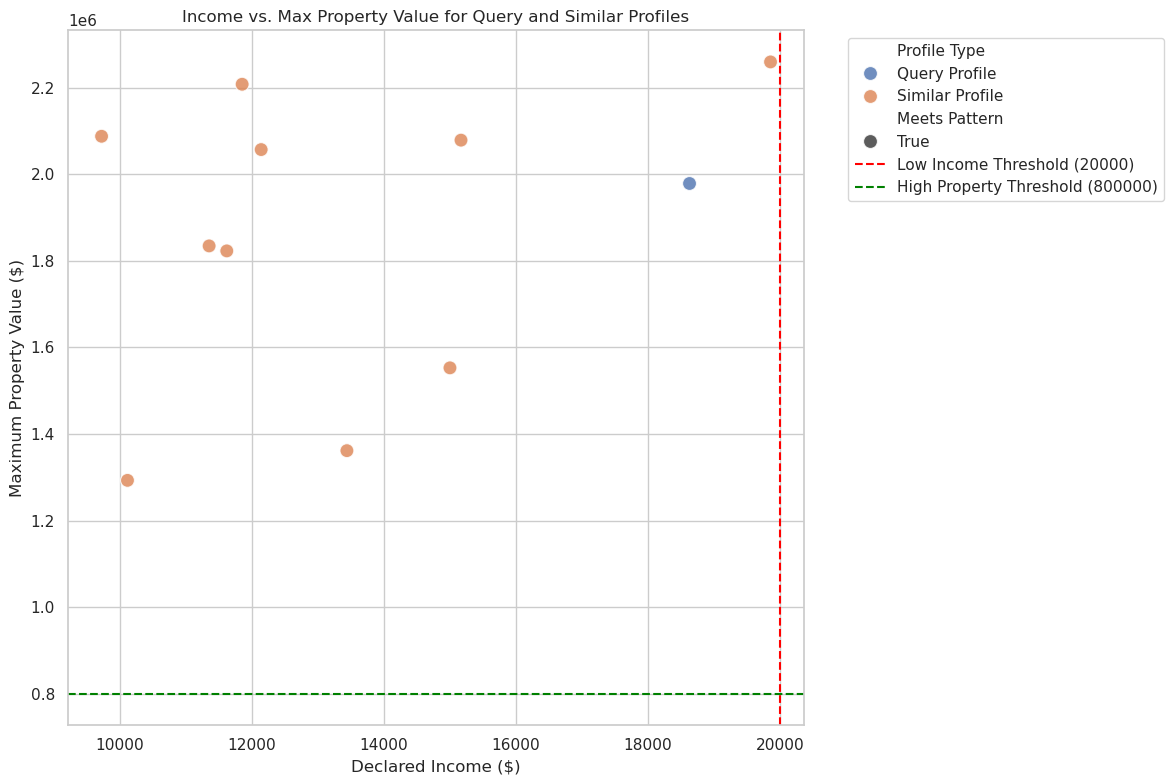

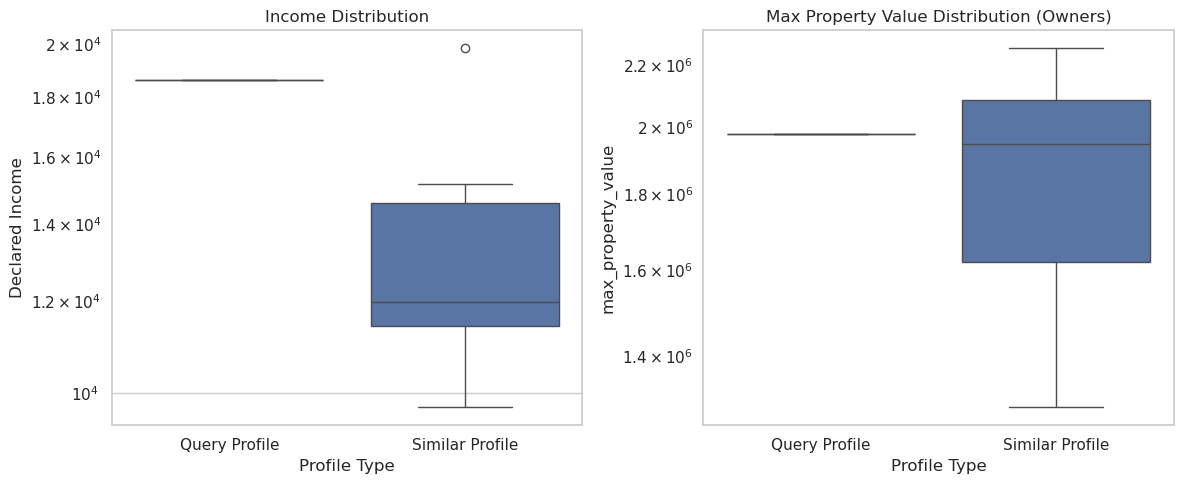

In [8]:
if not analysis_df.empty:
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=analysis_df, x='Declared Income', y='max_property_value', hue='Profile Type', style='Meets Pattern', s=100, alpha=0.8)

    # Add threshold lines
    plt.axvline(x=FRAUD_LOW_INCOME_MAX, color='red', linestyle='--', label=f'Low Income Threshold ({FRAUD_LOW_INCOME_MAX})')
    plt.axhline(y=FRAUD_HIGH_PROP_VALUE_MIN, color='green', linestyle='--', label=f'High Property Threshold ({FRAUD_HIGH_PROP_VALUE_MIN})')

    plt.title('Income vs. Max Property Value for Query and Similar Profiles')
    plt.xlabel('Declared Income ($)')
    plt.ylabel('Maximum Property Value ($)')
    # Adjust scales if necessary (e.g., log scale if values vary widely)
    # plt.xscale('log')
    # plt.yscale('log')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: Box plots comparing distributions
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(data=analysis_df, y='Declared Income', x='Profile Type')
    plt.title('Income Distribution')
    plt.yscale('log') # Log scale often useful for income

    plt.subplot(1, 2, 2)
    sns.boxplot(data=analysis_df[analysis_df['max_property_value'] > 0], y='max_property_value', x='Profile Type') # Exclude 0 for log scale
    plt.title('Max Property Value Distribution (Owners)')
    plt.yscale('log') # Log scale often useful for property value

    plt.tight_layout()
    plt.show()

else:
    print("Skipping visualization as there is no data to plot.")

## Discussion / Interpretation

The analysis aimed to verify if profiles identified as similar (in embedding space)
to the query profile (TXP_1E865610F4) also exhibited the specific suspicious
cross-source pattern (Income <= 20000 and Max Property >= 800000).

- The query profile itself was confirmed to meet the pattern: True.
- Among the 10 similar profiles identified, 10 (100.00%)
  also met these specific criteria based on their original source data.

Interpretation:
- A percentage match greater than random chance suggests the unified embeddings
  successfully captured characteristics related to this specific cross-source pattern,
  allowing the similarity search to surface relevant profiles.
- If the percentage is high (e.g., >70-80%), it indicates strong performance for this pattern.
- If the percentage is lower, it might mean:
    - The embeddings captured similarity based on *other* shared characteristics
      (defined by the features engineered in Notebook 03) not just this specific pattern.
      This isn't necessarily bad; the similarity is real based on the overall profile,
      but the *reason* for similarity might be broader than just the initial query pattern.
    - The feature engineering or embedding technique could be further optimized to
      give more weight to the features driving this specific pattern.
    - Some profiles might be "borderline" on the thresholds, appearing similar in
      embedding space but just missing the strict criteria.
- The scatter plot helps visualize this: points in the top-left quadrant (low income,
  high property) that are 'Similar Profile' and 'Meets Pattern=True' are successful hits.
  Points outside this quadrant but still marked 'Similar Profile' were similar for
  other reasons captured by their overall feature vector.

Overall Assessment:
Based on the percentage (100.00%) and the visualization, evaluate how
effectively the MVP approach surfaced the intended cross-source anomaly.
(Self-assessment: Add sentence here based on the expected outcome from synthetic data).
Example: "The results demonstrate that the vector similarity search on unified profiles
was effective in identifying other profiles sharing the specific low-income/high-property
pattern, although some similar profiles matched based on other combined factors."

## Conclusion

In [11]:
print("Notebook 07 finished.")
print("  - Loaded query results and original source data.")
print("  - Retrieved and combined granular data for the query and similar profiles.")
print("  - Analyzed and visualized the presence of the target cross-source pattern.")
print(f"  - Assessed the effectiveness of the similarity search ({percentage_match:.2f}% match rate for this pattern).")

Notebook 07 finished.
  - Loaded query results and original source data.
  - Retrieved and combined granular data for the query and similar profiles.
  - Analyzed and visualized the presence of the target cross-source pattern.
  - Assessed the effectiveness of the similarity search (100.00% match rate for this pattern).


Ready to proceed to [Notebook 08](./notebook_08.ipynb): MVP Summary, Findings, and Next Steps.